In [ ]:
%%capture
!pip install tf_gnns==0.1.8
!pip install tensorflow
!pip install tqdm

## The following are needed for data-loading
#
#   Older versions of pytorch geometric are needed because there was a change
# in loading the data that is not supported from the newer ones.
# This is the reason for the deprecation warning as well.
#
!pip install torch_geometric==2.5
!pip install torch==2.5

In [2]:
import torch
import tensorflow as tf
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import PPI
from tqdm import tqdm
import matplotlib.pyplot as pplot

In [3]:
## Transformations from pytorch geometric to tf_gnns:
def _pt_to_tf(x):
    x_dl = torch.utils.dlpack.to_dlpack(x)
    return tf.experimental.dlpack.from_dlpack(x_dl)

def _infer_n_nodes(dbatch):
    n_nodes = tf.cast(
        tf.math.segment_sum(tf.ones(tf.shape(dbatch.batch)[0]), dbatch.batch), tf.int64
    )
    return n_nodes

def _infer_n_edges(dbatch, n_nodes):
    """DGL/PyG batches don't contain n_nodes and n_edges.
    When performing global aggregations per-graph, we need these
    to correctly aggregate the graph outputs.

    This utility function infers from the pyg databatch the n_edges and n_nodes
    per graph. The function is fully vectorized and should have minimal overhead.
    """
    nnodes_cumsum = tf.cumsum(n_nodes)[...,tf.newaxis]
    _dd1 = dbatch.edge_index[0] < nnodes_cumsum
    _dd2 = dbatch.edge_index[1] < nnodes_cumsum
    _c1 = tf.reduce_sum(tf.cast(_dd1, tf.int64), axis = 1)
    _c2 = tf.reduce_sum(tf.cast(_dd2, tf.int64), axis = 1)
    edge_offsets = tf.reduce_max(tf.stack([_c1, _c2]),0)-1
    n_edges = tf.concat([edge_offsets[0][tf.newaxis], edge_offsets[1:] - edge_offsets[:-1]], axis = 0)
    return n_edges

def _dgl_databatch_to_tfgnn_graph_tuple(dbatch, infer_n_edges = False):
    """TFGNNs uses a simple dictionary of tensorflow tensors for input data.
    The TFGNN model constructors will skip creating a global variable and
    global message passing (e.g., node-to-global, edge-to-global)
    if there is no global variable in the inputs.
    """
    x =  _pt_to_tf(dbatch.x)
    y =  _pt_to_tf(dbatch.y)
    edges = _pt_to_tf(dbatch.edge_index)
    n_graphs = dbatch.num_graphs
    n_nodes = _infer_n_nodes(dbatch)

    dd = {
        'senders' : edges[0],
        'receivers' : edges[1],
        'edges' : tf.ones((tf.shape(edges)[1],1 ) ),
        'nodes' : x,
        'n_nodes' : n_nodes,
        'n_graphs' : tf.constant(n_graphs)
    }
    if infer_n_edges:
        dd['n_edges'] = _infer_n_edges(dbatch, n_nodes)
    return dd, y

_ppi_docstring_ = PPI.__doc__

class TfgPPI:
    __doc__=f"""A wrapper to the pytorch_geometric (pyg) data classes and data loaders.
    It uses the loaders from `pyg` to get pytorch tensors, and `dlpack` to transform
    them in-memory to `tensorflow` tensors compatible with tf_gnns.

    Because the PPI dataset has a relatively small memory footprint,
    the data can be pre-transformed in-memory.

    Args:
        ppi_root : the root dir to be passed into the wrapped class
        split : (str) 'train' or 'test'/'val'.

    ----------------------------------------------------------------------------
    Wrapped class docstring (parameters of wrapped class are irrelevant)
    shown for easier reference:
    ----------------------------------------------------------------------------

    {_ppi_docstring_}
    """
    def __init__(self, ppi_root : str = '.ppi_cache',split : str= 'train'):
        self.ppi_root = ppi_root
        self.ppi_obj = PPI(ppi_root, split = split)


    def generator(self, batch_size = 1, shuffle = True, for_pyg = False):
        for g in DataLoader(self.ppi_obj, batch_size=batch_size, shuffle=shuffle):
            if for_pyg:
                yield g
            else:
                yield _dgl_databatch_to_tfgnn_graph_tuple(g)
    def get_prepared_data(self,batch_size = 1, shuffle = True, for_pyg = False):
        return [gg for gg in self.generator(batch_size=batch_size, shuffle = shuffle, for_pyg = for_pyg)]

In [4]:
train_data = TfgPPI(ppi_root = '.', split='train').get_prepared_data(batch_size=1, shuffle = True)
val_data = TfgPPI(ppi_root = '.', split='val').get_prepared_data(batch_size=2, shuffle = True)
test_data = TfgPPI(ppi_root = '.', split='test').get_prepared_data(batch_size=2, shuffle = True)

Extracting ./ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/io/fs.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed durin

In [6]:
from tf_gnns import GraphNetMPNN_MLP, GraphIndep
from tf_gnns.lib.gt_ops import _assign_add_tensor_dict

In [7]:
from tf_gnns import GNCellMLP
def _assign_add_tensor_dict_noglobals(d_,od):
    d_['nodes']       = d_['nodes']       + od['nodes']
    d_['edges']       = d_['edges']       + od['edges']
    return d_

class MPNNNodeClassifier(tf.keras.Model):
    def __init__(self, enc_units = 32, mpnn_units = 128, mp_steps = 2, n_classes_out = 121):
        super(MPNNNodeClassifier,self).__init__()
        self.mp_steps = mp_steps
        self.g_enc = GraphIndep(enc_units)
        self.core_gns = []

        self.mpnn_units = mpnn_units
        for c in range(self.mp_steps):
            self.core_gns.append(GNCellMLP(self.mpnn_units))

        # project nodes to n_classes_out:
        self.node_dec = tf.keras.layers.Dense(n_classes_out)

    def call(self, graph_in, return_logits = False):
        _g = self.g_enc(graph_in)

        for m in self.core_gns:
            _g_new = m(_g)
            _g = _assign_add_tensor_dict_noglobals(_g, _g_new)
        res = self.node_dec(_g['nodes'])
        if return_logits:
            return res
        else:
            return tf.nn.sigmoid(res)

In [8]:
n_classes = train_data[0][1].shape[1]
model = MPNNNodeClassifier(enc_units=512, mpnn_units=512, mp_steps = 4, n_classes_out=n_classes)


In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.)

In [10]:
train_data = TfgPPI(ppi_root = '.', split='train').get_prepared_data(batch_size=2, shuffle = True, for_pyg = False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

In [11]:
@tf.function
def train_step(y_true, g_inp):
    with tf.GradientTape() as tape:
        x_out = model(g_inp, return_logits = True)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, x_out)
        grad = tape.gradient(loss, model.weights)
        opt.apply_gradients(zip(grad, model.weights))
    return tf.reduce_mean(loss)

@tf.function
def _full_set_loss_comp(which_set = 'train'):
    set_dict = {
        'train' : train_data,
        'test' : test_data,
        'val' : val_data
    }
    losses = []
    for g_in , y in set_dict[which_set]:
        res = model(g_in, return_logits = True)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(y, res)
        losses.append(loss)
    return tf.reduce_mean(losses)


In [12]:
train_losses = []
val_losses = []
test_losses = []

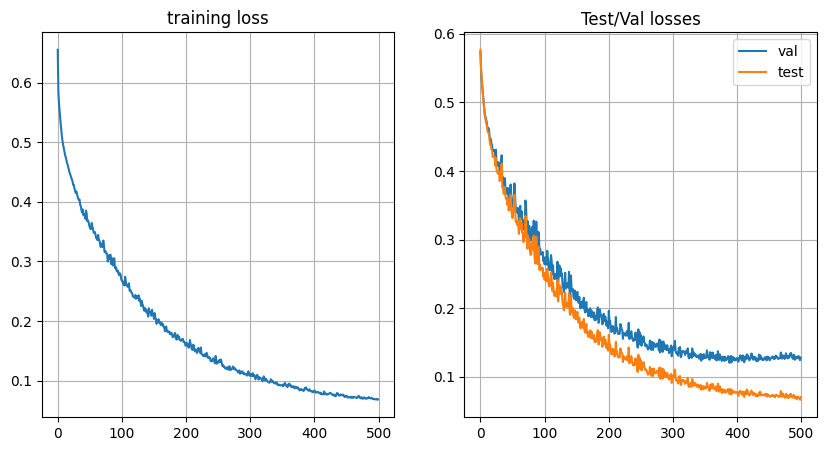

100%|██████████| 500/500 [12:43<00:00,  1.53s/it]


In [13]:
from IPython.display import clear_output
import numpy as np

num_epochs = 500
for e in tqdm(range(num_epochs)):

    _train_losses = []
    for graph_inp, labels in tqdm(train_data):
        l = train_step( labels, graph_inp)
        _train_losses.append(l)
    train_losses.append(np.mean(_train_losses))
    val_losses.append(_full_set_loss_comp('val'))
    test_losses.append(_full_set_loss_comp('test'))
    clear_output()
    pplot.figure(figsize = (10,5), dpi  =100)
    pplot.subplot(1,2,1)
    pplot.plot(train_losses)
    pplot.title('training loss')
    pplot.grid()
    pplot.subplot(1,2,2)

    pplot.plot(val_losses,label = 'val')
    pplot.plot(test_losses,label = 'test')
    pplot.title('Test/Val losses')
    pplot.grid()
    pplot.legend()
    pplot.pause(.1)

## Evaluation

In [14]:
test_node_vals, test_pred = test_data[0][1], model(test_data[0][0]) # test data contains only 1 graph.

In [15]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
roc_auc_scores = [roc_auc_score(test_node_vals[:,i], test_pred[:,i]) for i in range(test_node_vals.shape[1])]
f1_scores = [f1_score(test_node_vals[:,i], test_pred[:,i]>.5) for i in range(test_node_vals.shape[1])]
accuracy_scores = [accuracy_score(test_node_vals[:,i], test_pred[:,i]>.5) for i in range(test_node_vals.shape[1])]

In [16]:
import pandas as pd
pd.set_option('display.max_rows',None)
test_set_metrics = pd.DataFrame([roc_auc_scores, f1_scores, accuracy_scores]).T
test_set_metrics.columns = ['roc_auc_scores', 'f1_scores', 'accuracy_scores']
test_set_metrics.mean()

,0
roc_auc_scores,0.995957
f1_scores,0.974881
accuracy_scores,0.987035


## Comparison with other models

| Metric | GAT     | this model|
|--------|---------|-----------|
| F1     |  0.973  |   0.975   |


The model performance in F1 score is comparable with the GAT reported in the [Graph Attention Networks](https://arxiv.org/pdf/1710.10903v3) paper.

It's possible that with further hyper-parameter tuning or using some self-supervision tricks (e.g., pre-training the newtork on constrastive tasks or as an autoencoder) can bring the performance to state of the art.

